In [26]:
import pandas as pd 
import numpy as np
import os 
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plots
markers = ['o', 's', 'D', 'v', 'p', 'P', 'X', 'h', 'H', 'd']
colors_discrete = sns.color_palette('tab10')
colors_continuous = sns.color_palette('viridis')
linestyles = ['-', '--', '-.', ':']


# Do not hide any columns
pd.set_option('display.max_columns', None)

results_path = 'results_combined'
images_dir = f'{results_path}/images'

# Read all the results from results/ directory
results = []
for dirs in os.listdir(results_path):
    if 'results' in dirs:
        if not os.path.isdir(f'{results_path}/{dirs}'):
            continue
        for file in os.listdir(f'{results_path}/{dirs}/results'):
            if file.endswith('.feather'):
                results.append(pd.read_feather(f'{results_path}/{dirs}/results/{file}'))

# Concatenate all the results
raw_df: pd.DataFrame = pd.concat(results, ignore_index=True)
print(raw_df.info())
raw_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195754 entries, 0 to 195753
Data columns (total 47 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   experiment_type                                 195754 non-null  object 
 1   dataset_name                                    195754 non-null  object 
 2   k_mlps_in_B                                     195754 non-null  int64  
 3   fold_i                                          195754 non-null  int64  
 4   experiment_generalization_type                  195754 non-null  object 
 5   beta_confidence                                 195754 non-null  float64
 6   delta_robustness                                195754 non-null  float64
 7   model2_name                                     195754 non-null  object 
 8   x_test_sample                                   195754 non-null  object 
 9   y_test_sample             

,experiment_type,dataset_name,k_mlps_in_B,fold_i,experiment_generalization_type,beta_confidence,delta_robustness,model2_name,x_test_sample,y_test_sample,model1_pred_proba,model1_pred_crisp,model2_pred_proba,model2_pred_crisp,base_counterfactual,base_counterfactual_model1_pred_proba,base_counterfactual_model1_pred_crisp,base_counterfactual_model2_pred_proba,base_counterfactual_model2_pred_crisp,base_counterfactual_validity,base_counterfactual_proximityL1,base_counterfactual_proximityL2,base_counterfactual_plausibility,base_counterfactual_discriminative_power,base_counterfactual_validity_model2,base_counterfactual_time,robust_counterfactual,robust_counterfactual_model1_pred_proba,robust_counterfactual_model1_pred_crisp,robust_counterfactual_model2_pred_proba,robust_counterfactual_model2_pred_crisp,robust_counterfactual_validity,robust_counterfactual_proximityL1,robust_counterfactual_proximityL2,robust_counterfactual_plausibility,robust_counterfactual_discriminative_power,robust_counterfactual_validity_model2,robust_counterfactual_L1_distance_from_base_cf,robust_counterfactual_L2_distance_from_base_cf,robust_counterfactual_time,start_sample_passes_test,counterfactual_does_not_pass_test,counterfactual_does_not_have_target_class,counterfactual_is_nan,highest_delta,lower_bound_beta,upper_bound_beta
0,Seed-Architecture,wine_quality,32,2,Seed-Architecture,0.95,0.9,Model2_1,"[0.2711864406779661, 0.43666666666666665, 0.03...",0,0.293811,0,0.293811,0,"[0.2787898212382317, 0.43329379251648725, 0.03...",0.512232,1,0.512232,1,1,0.14428,0.057941,0.105666,0.2,1,0.002416,"[0.34373081130734445, 0.41317883565146324, 0.1...",0.934374,1.0,0.934374,1.0,1.0,0.860903,0.289157,0.235444,0.866667,1.0,0.781579,0.068859,5.673441,0.0,0.0,0.0,0.0,0.925072,0.925072,0.999985
1,Seed-Architecture,wine_quality,32,2,Seed-Architecture,0.95,0.9,Model2_2,"[0.2711864406779661, 0.43666666666666665, 0.03...",0,0.293811,0,0.198473,0,"[0.2787898212382317, 0.43329379251648725, 0.03...",0.512232,1,0.241726,0,1,0.14428,0.057941,0.105666,0.2,0,0.002416,"[0.24282515077700773, 0.29980200972634685, 0.1...",0.919469,1.0,0.743397,1.0,1.0,0.817887,0.267339,0.190344,0.866667,1.0,0.740411,0.063066,5.667662,0.0,0.0,0.0,0.0,0.925072,0.925072,0.999985
2,Seed-Architecture,wine_quality,32,2,Seed-Architecture,0.95,0.9,Model2_3,"[0.2711864406779661, 0.43666666666666665, 0.03...",0,0.293811,0,0.275743,0,"[0.2787898212382317, 0.43329379251648725, 0.03...",0.512232,1,0.386663,0,1,0.14428,0.057941,0.105666,0.2,0,0.002416,"[0.22433824930593615, 0.2695597718665149, 0.19...",0.725812,1.0,0.769066,1.0,1.0,0.899446,0.335270,0.181018,0.733333,1.0,0.919974,0.110261,7.529212,0.0,0.0,0.0,0.0,0.925072,0.925072,0.999985
3,Seed-Architecture,wine_quality,32,2,Seed-Architecture,0.95,0.9,Model2_4,"[0.2711864406779661, 0.43666666666666665, 0.03...",0,0.293811,0,0.177562,0,"[0.2787898212382317, 0.43329379251648725, 0.03...",0.512232,1,0.226303,0,1,0.14428,0.057941,0.105666,0.2,0,0.002416,"[0.330466105049619, 0.3454530448579557, 0.0780...",0.931067,1.0,0.750817,1.0,1.0,0.856605,0.299417,0.235085,0.800000,1.0,0.794499,0.079007,5.667757,0.0,0.0,0.0,0.0,0.925072,0.925072,0.999985
4,Seed-Architecture,wine_quality,32,2,Seed-Architecture,0.95,0.9,Model2_5,"[0.2711864406779661, 0.43666666666666665, 0.03...",0,0.293811,0,0.194873,0,"[0.2787898212382317, 0.43329379251648725, 0.03...",0.512232,1,0.243201,0,1,0.14428,0.057941,0.105666,0.2,0,0.002416,"[0.19879335388877922, 0.2723408439095289, 0.02...",0.954808,1.0,0.832119,1.0,1.0,0.994509,0.333236,0.242185,0.800000,1.0,0.933914,0.099068,7.541861,0.0,0.0,0.0,0.0,0.925072,0.925072,0.999985


In [37]:
# Prep
raw_df = raw_df[~((raw_df['delta_robustness'] == 0.9) & (raw_df['robust_counterfactual_plausibility'].isna()))]
raw_df = raw_df[raw_df['dataset_name'] != 'breast_cancer']

In [38]:
np.sum(((raw_df['delta_robustness'] == 0.7).to_numpy() & raw_df['robust_counterfactual_plausibility'].notna().to_numpy()))

21600

In [39]:
np.sum((raw_df['start_sample_passes_test'] == 0))

85717

In [40]:
raw_df['start_sample_passes_test'].value_counts()

0.0    85717
1.0    20520
Name: start_sample_passes_test, dtype: int64

In [41]:
base_validity_model2 = raw_df[raw_df['base_counterfactual'] != None]['base_counterfactual_validity_model2']
print('Average base_counterfactual_validity_model2:', base_validity_model2.mean())
print('Notna %:', base_validity_model2.notna().sum() / base_validity_model2.shape[0])

robust_validity_model2 = raw_df[raw_df['robust_counterfactual'] != None]['robust_counterfactual_validity_model2']
print('Average robust_counterfactual_validity_model2:', robust_validity_model2.mean())
print('Notna %:', robust_validity_model2.notna().sum() / robust_validity_model2.shape[0])

Average base_counterfactual_validity_model2: 0.5204286024567416
Notna %: 0.3241393336827366
Average robust_counterfactual_validity_model2: 0.8634374088123723
Notna %: 0.8310348334206842


In [42]:
raw_df['dataset_name'].value_counts()

wine_quality    64800
fico            63037
Name: dataset_name, dtype: int64

In [43]:
raw_df['experiment_type'].value_counts()

Seed-Architecture              32400
Bootstrap-Architecture         32400
Seed-Bootstrap                 32347
Seed-Bootstrap-Architecture    30690
Name: experiment_type, dtype: int64

In [44]:
raw_df['beta_confidence'].value_counts()

0.95    127837
Name: beta_confidence, dtype: int64

In [45]:
raw_df['delta_robustness'].value_counts()

0.5    43200
0.8    21600
0.6    21600
0.7    21600
0.9    19837
Name: delta_robustness, dtype: int64

In [46]:
def filter_by(df, dataset_name=None, experiment_type=None, beta_confidence=None, delta_robustness=None):
    if dataset_name is not None:
        df = df[df['dataset_name'] == dataset_name]
    if experiment_type is not None:
        df = df[df['experiment_type'] == experiment_type]
    if beta_confidence is not None:
        df = df[df['beta_confidence'] == beta_confidence]
    if delta_robustness is not None:
        df = df[df['delta_robustness'] == delta_robustness]
    return df

In [47]:

def plot_validity_by_delta(df, dataset_name, beta_confidence, experiment_type):    
    robust_optim = []
    robust_optim_ci = []
    robust_start = []
    robust_start_ci = []
    robust_combined = []
    robust_combined_ci = []
    base = []
    base_ci = []
    
    z = 1.96  # z-score for 95% confidence
    
    unique_deltas = sorted(df['delta_robustness'].unique())
    print(unique_deltas)

    exp1_df = filter_by(raw_df.copy(), dataset_name=dataset_name, experiment_type=experiment_type, beta_confidence=beta_confidence)
    print(f'Filtered df shape: {exp1_df.shape}')

    for delta in unique_deltas:
        robust_data = exp1_df[(exp1_df['delta_robustness'] == delta) & (exp1_df['beta_confidence'] == beta_confidence) & (exp1_df['start_sample_passes_test'] == 0)]['robust_counterfactual_validity_model2'].dropna()
        
        if len(robust_data) == 0:
            print('Nan found')
            robust_optim.append(0)
            robust_optim_ci.append(0)
        else:
            robust_mean = robust_data.mean()
            robust_optim.append(robust_mean)
            robust_optim_ci.append(z * np.sqrt((robust_mean*(1-robust_mean))/len(robust_data)))
            
        robust_data = exp1_df[(exp1_df['delta_robustness'] == delta) & (exp1_df['beta_confidence'] == beta_confidence) & (exp1_df['start_sample_passes_test'] == 1)]['robust_counterfactual_validity_model2'].dropna()
        if len(robust_data) == 0:
            print('Nan found')
            robust_start.append(0)
            robust_start_ci.append(0)
        else:
            robust_mean = robust_data.mean()
            robust_start.append(robust_mean)
            robust_start_ci.append(z * np.sqrt((robust_mean*(1-robust_mean))/len(robust_data)))
        
        robust_data = exp1_df[(exp1_df['delta_robustness'] == delta) & (exp1_df['beta_confidence'] == beta_confidence)]['robust_counterfactual_validity_model2'].dropna()
        if len(robust_data) == 0:
            print('Nan found')
            robust_combined.append(0)
            robust_combined_ci.append(0)
        else:
            robust_mean = robust_data.mean()
            robust_combined.append(robust_mean)
            robust_combined_ci.append(z * np.sqrt((robust_mean*(1-robust_mean))/len(robust_data)))

        base_data = exp1_df[(exp1_df['delta_robustness'] == delta) & (exp1_df['beta_confidence'] == beta_confidence)]['base_counterfactual_validity_model2'].dropna()
        base_mean = base_data.mean()
        base.append(base_mean if not pd.isna(base_mean) else base[0])
        base_ci.append(z * np.sqrt((base_mean*(1-base_mean))/len(base_data)) if not pd.isna(base_mean) else base_ci[0])


    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    # plt.title(f'Empirical validity for model 2 @ {int(beta_confidence*100)}% (Beta) confidence \nWith 95% confidence error bars')
    plt.xlabel('Delta-robustness threshold')
    plt.ylabel('Validity for model 2')

    plt.errorbar(unique_deltas, base, yerr=base_ci, label='Base cf', marker=markers[3], color=colors_discrete[3], linestyle=linestyles[3])
    plt.errorbar(unique_deltas, robust_start, yerr=robust_start_ci, label='Robust cf (Base passed)', marker=markers[2], color=colors_discrete[2], linestyle=linestyles[2])
    plt.errorbar(unique_deltas, robust_optim, yerr=robust_optim_ci, label='Robust cf (Optimized)', marker=markers[1], color=colors_discrete[1], linestyle=linestyles[1])
    plt.errorbar(unique_deltas, robust_combined, yerr=robust_combined_ci, label='Robust cf (Combined)', marker=markers[0], color=colors_discrete[0], linestyle=linestyles[0])

    plt.grid(axis='y')
    # Add some offset to the legend
    # plt.legend(loc='right', fontsize='small', title='Counterfactual type', title_fontsize='small', bbox_to_anchor=(1, -0.5), ncol=2)
    plt.tight_layout()
    
    os.makedirs(f'{images_dir}/plot_validity_by_delta', exist_ok=True)
    plt.savefig(f'{images_dir}/plot_validity_by_delta/{dataset_name}_{experiment_type}_{int(beta_confidence*100)}.png', dpi=300, bbox_inches='tight')
    
    # Create separate legend plot and save it
    _, ax2 = plt.subplots(1, 1, figsize=(4, 1))
    ax2.axis('off')
    ax2.legend(*ax.get_legend_handles_labels(), loc='center', title='Counterfactual type',  ncol=4)
    plt.tight_layout()
    plt.savefig(f'{images_dir}/plot_validity_by_delta/legend.png', dpi=300, bbox_inches='tight')
    
    # Flush the plot
    plt.close()
    
    return None
    

[0.5, 0.6, 0.7, 0.8, 0.9]
Filtered df shape: (16200, 47)


/tmp/ipykernel_16098/795549710.py:80: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


[0.5, 0.6, 0.7, 0.8, 0.9]
Filtered df shape: (16200, 47)
[0.5, 0.6, 0.7, 0.8, 0.9]
Filtered df shape: (16200, 47)
[0.5, 0.6, 0.7, 0.8, 0.9]
Filtered df shape: (16200, 47)
[0.5, 0.6, 0.7, 0.8, 0.9]
Filtered df shape: (16200, 47)
[0.5, 0.6, 0.7, 0.8, 0.9]
Filtered df shape: (14490, 47)
[0.5, 0.6, 0.7, 0.8, 0.9]
Filtered df shape: (16200, 47)
[0.5, 0.6, 0.7, 0.8, 0.9]
Filtered df shape: (16147, 47)
Done


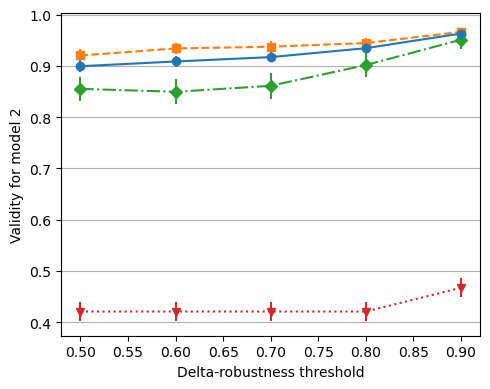

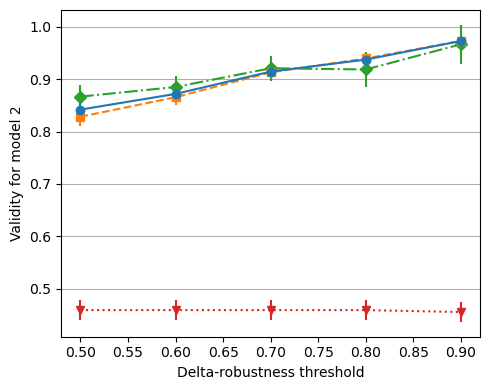

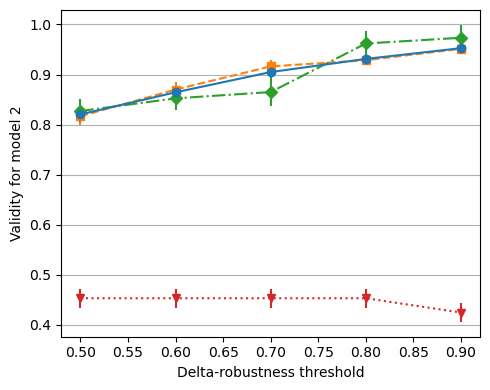

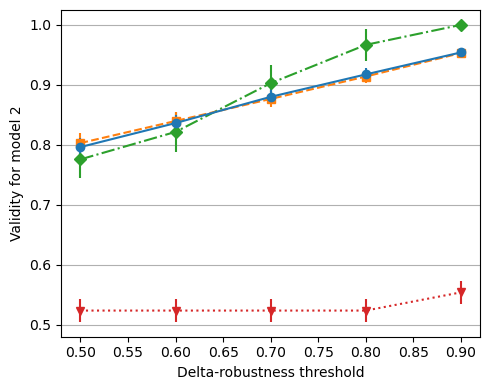

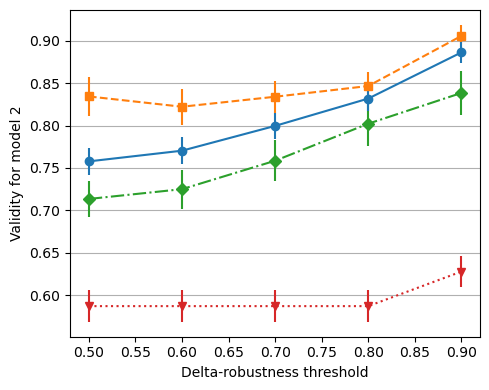

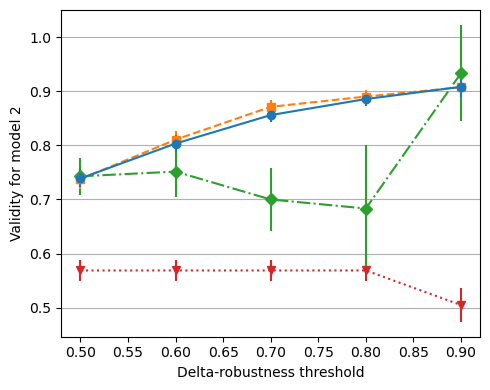

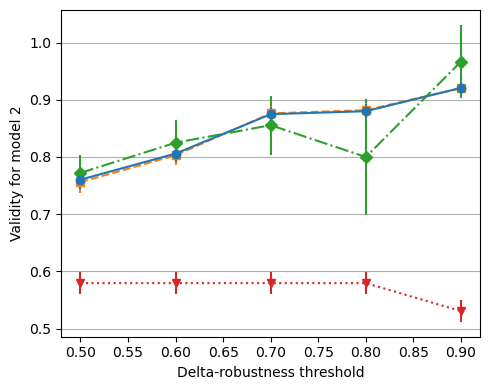

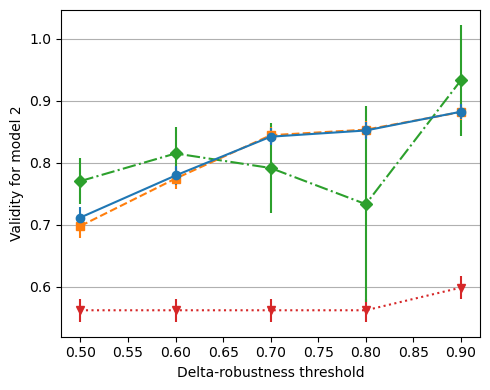

In [48]:
import numpy as np

confidence = 0.95

for dataset_name in raw_df['dataset_name'].unique():
    for experiment_type in raw_df['experiment_type'].unique():
        for beta_confidence in raw_df['beta_confidence'].unique():
            _ = plot_validity_by_delta(raw_df, dataset_name, beta_confidence, experiment_type)
            
print('Done')

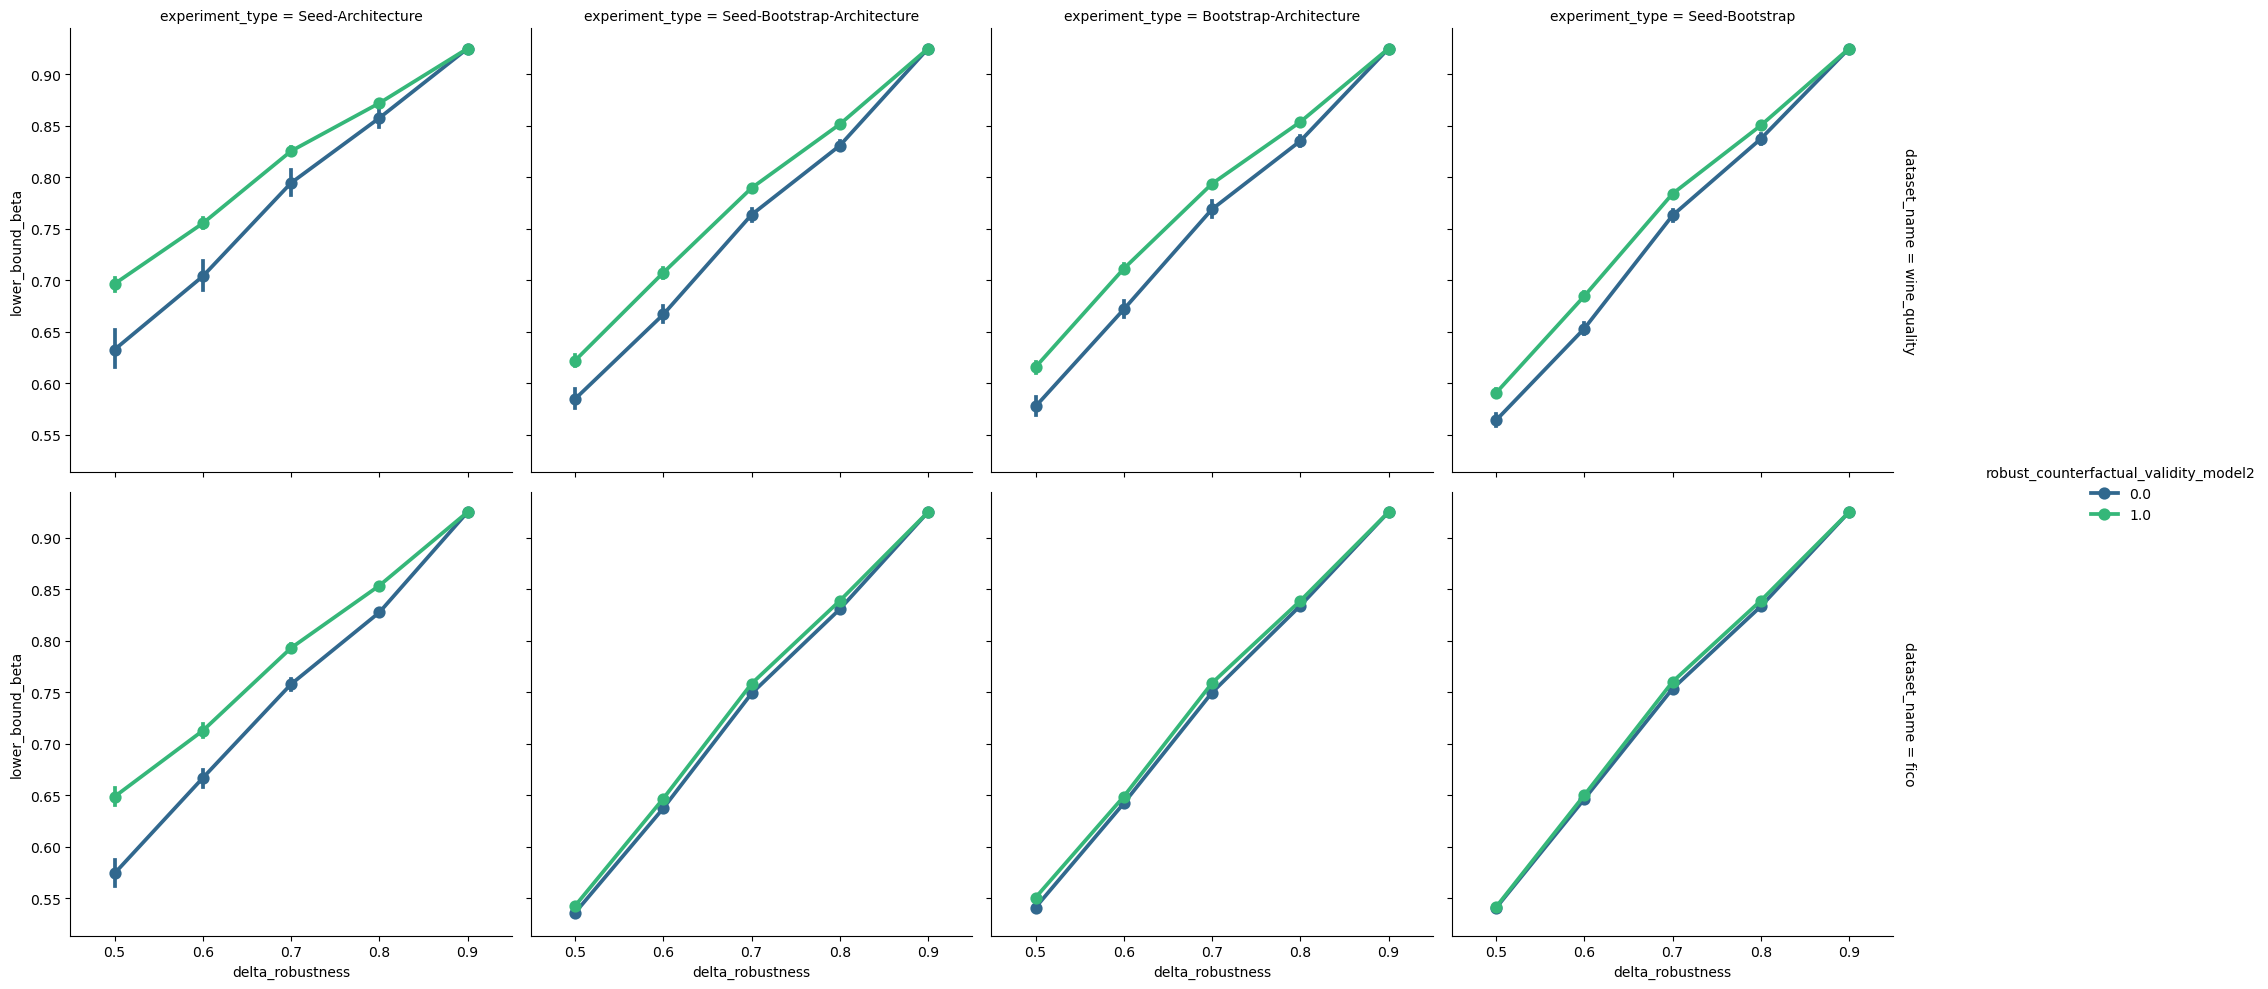

In [49]:
sns.catplot(data=raw_df,
            # data selection 
            x='delta_robustness', 
            y='lower_bound_beta', 
            col='experiment_type', 
            row='dataset_name', 
            hue='robust_counterfactual_validity_model2', 
            # settings
            kind='point', 
            # errorbar='se',
            # fill=True, 
            palette='viridis',  
            margin_titles=True,
        
)

os.makedirs(f'{images_dir}/misc', exist_ok=True)
plt.savefig(f'{images_dir}/misc/delta_robustness_vs_lower_bound_beta.png', dpi=300, bbox_inches='tight')



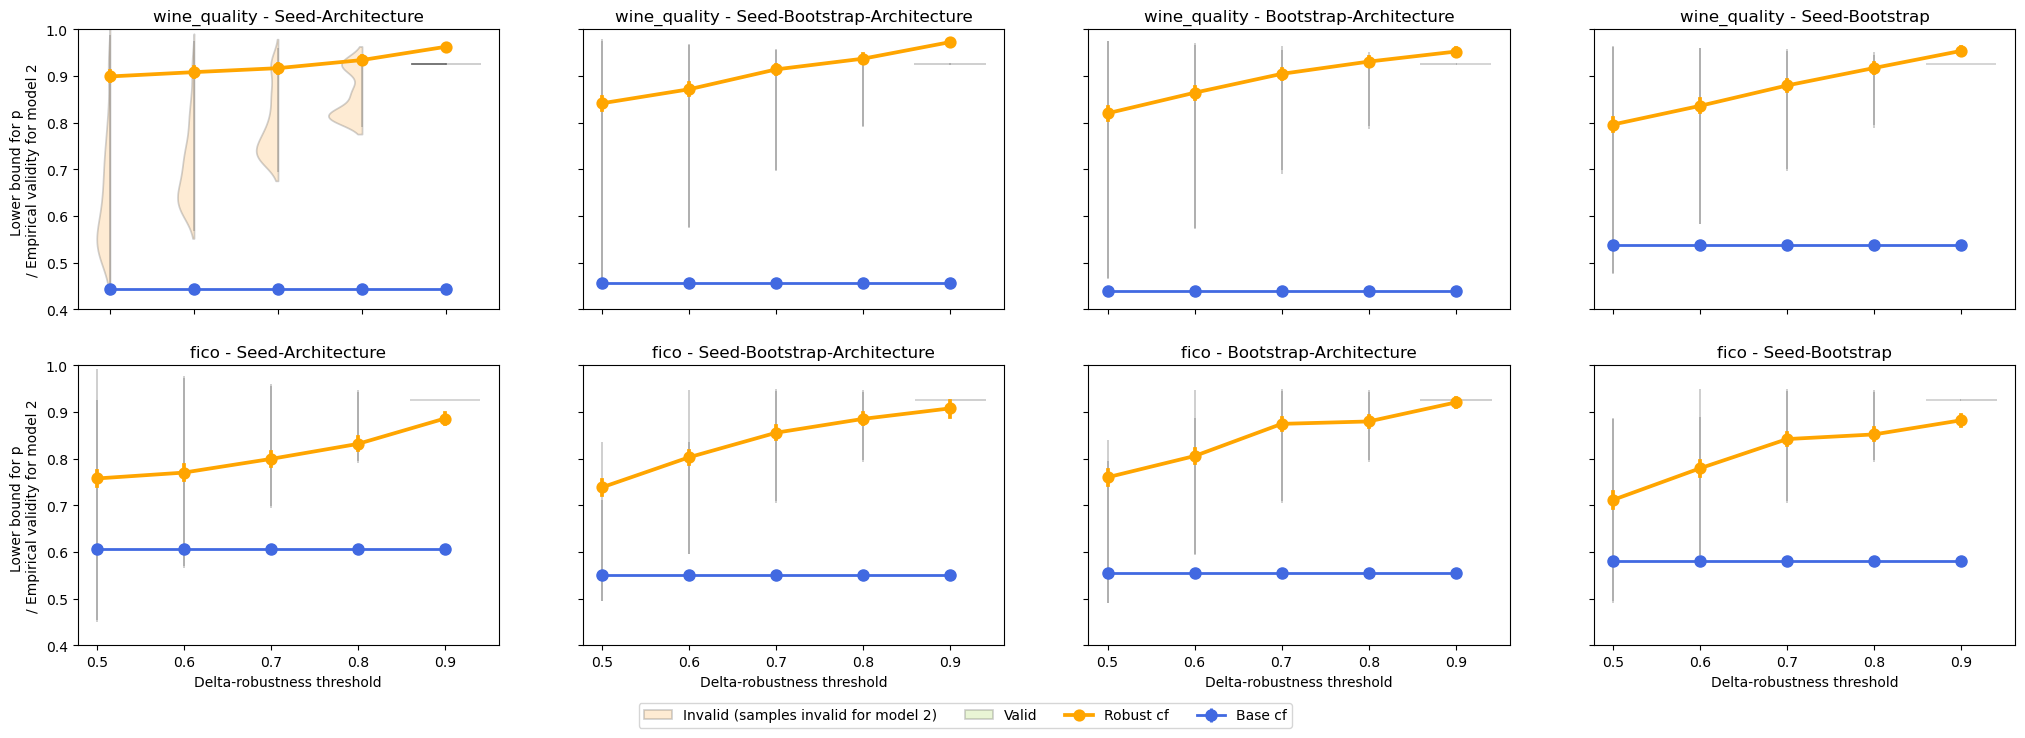

In [50]:
# Create an aggregated plot of the average validity for model 2
rows = len(raw_df['dataset_name'].unique())
cols = len(raw_df['experiment_type'].unique())
fig, ax = plt.subplots(rows, cols, figsize=(25, 8))



# Add horizontal line plots for the base counterfactual validity
axes = ax.flatten()
for i, dataset in enumerate(raw_df['dataset_name'].unique()):
    for j, experiment in enumerate(raw_df['experiment_type'].unique()):
        ax = axes[i * cols + j]
        
        sns.violinplot(data=raw_df[(raw_df['dataset_name'] == dataset) & (raw_df['experiment_type'] == experiment)], 
                       x='delta_robustness', 
                       y='lower_bound_beta', 
                       hue='robust_counterfactual_validity_model2', 
                       split=True, 
                       inner=None,
                       legend=True if i == rows - 1 and j == cols - 1 else False,
                       ax=ax,
                       alpha=0.3,
                       saturation=1,
                       palette='RdYlGn',
        )
        
        sns.pointplot(data=raw_df[(raw_df['dataset_name'] == dataset) & (raw_df['experiment_type'] == experiment)],
                    # data selection 
                    x='delta_robustness', 
                    y='robust_counterfactual_validity_model2', 
                    errorbar='ci',
                    legend=True if i == rows - 1 and j == cols - 1 else False,
                    color='orange',
                    ax=ax,
                    label='Robust cf',
                
        )
        
        
        
        mean = raw_df[(raw_df['dataset_name'] == dataset) & (raw_df['experiment_type'] == experiment)]['base_counterfactual_validity_model2'].mean()
        # ax.axhline(mean, color='royalblue', linestyle='-', linewidth=2)
        # add std error bars at each point
        se = raw_df[(raw_df['dataset_name'] == dataset) & (raw_df['experiment_type'] == experiment)]['base_counterfactual_validity_model2'].sem()
        
        ticks = ax.get_xticks()
        ax.errorbar(ticks, [mean] * len(ticks), yerr=[se] * len(ticks), color='royalblue', linestyle='-', label='Base cf', linewidth=2, marker='o', markersize=8)
        
        if j == 0:
            ax.set_ylabel('Lower bound for p \n/ Empirical validity for model 2')
        else: 
            ax.set_ylabel('')
            ax.set_yticklabels([])
        if i == rows - 1:
            ax.set_xlabel('Delta-robustness threshold')
        else:
            ax.set_xlabel('')
            if i == 0:
                ax.set_xticklabels([])
            
        
            
        ax.set_title(f'{dataset} - {experiment}')
        
        # Make sure that y-axis is shared between the plots 
        ax.set_ylim(0.4, 1)
        ax.set_yticks(np.arange(0.4, 1.1, 0.1))
                
# Create the legend
handles, labels = ax.get_legend_handles_labels()

labels = ['Invalid (samples invalid for model 2)', 'Valid', 'Robust cf', 'Base cf']

plt.legend(handles, labels, loc='center right', ncol=5, bbox_to_anchor=(-0.7, -0.25))

os.makedirs(f'{images_dir}/misc', exist_ok=True)
plt.savefig(f'{images_dir}/misc/combined_violinplot.png', dpi=300, bbox_inches='tight')

        
        

In [93]:


tmp_df = raw_df.copy()
tmp_df['mid-point_beta'] = (tmp_df['lower_bound_beta'] + tmp_df['upper_bound_beta']) / 2
tmp_df['lower_bound_beta'] = tmp_df['lower_bound_beta'].round(2)
tmp_df['mid-point_beta'] = tmp_df['mid-point_beta'].round(2)
tmp_df['upper_bound_beta'] = tmp_df['upper_bound_beta'].round(2)


# Create a table with the average validity for model 2 and lower, mid, upper beta intervals for each dataset
table = tmp_df.groupby(['dataset_name']).agg(
    base_counterfactual_validity_model2=('base_counterfactual_validity_model2', 'mean'),
    robust_counterfactual_validity_model2=('robust_counterfactual_validity_model2', 'mean'),
    lower_bound_beta=('lower_bound_beta', 'mean'),
    mid_point_beta=('mid-point_beta', 'mean'),
    upper_bound_beta=('upper_bound_beta', 'mean'),
)

# Shorten the column names
table.columns = ['Base cf', 'Robust cf', 'Lower bound beta', 'Mid-point beta', 'Upper bound beta']
table  = table.round(2)

print(table)



              Base cf  Robust cf  Lower bound beta  Mid-point beta  \
dataset_name                                                         
fico             0.58       0.82              0.76            0.85   
wine_quality     0.47       0.90              0.80            0.88   

              Upper bound beta  
dataset_name                    
fico                      0.95  
wine_quality              0.97  


/tmp/ipykernel_16098/1131222546.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels([f'{float(label.get_text()):.2f}' for label in xtick_labels])


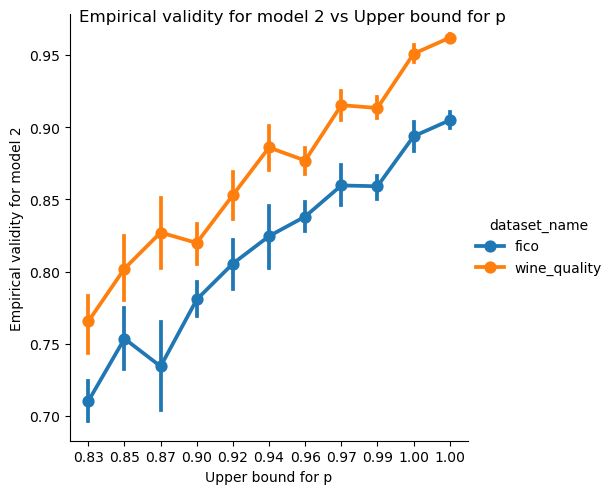

In [17]:
g = sns.catplot(data=raw_df,
            # data selection 
            x='upper_bound_beta', 
            y='robust_counterfactual_validity_model2', 
            errorbar='ci',
            hue='dataset_name',
            # ax=ax,
            kind='point',
)

xtick_labels = g.ax.get_xticklabels()
g.ax.set_xticklabels([f'{float(label.get_text()):.2f}' for label in xtick_labels])

g.set_axis_labels('Upper bound for p', 'Empirical validity for model 2')
plt.suptitle('Empirical validity for model 2 vs Upper bound for p')

plt.savefig(f'{images_dir}/misc/validity_vs_upper_bound_beta.png', dpi=300, bbox_inches='tight')


/tmp/ipykernel_16098/3582114858.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels([f'{float(label.get_text()):.2f}' for label in xtick_labels])


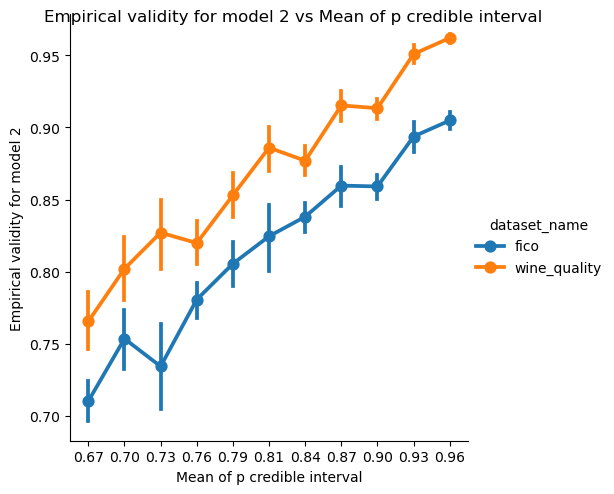

In [18]:
_df = raw_df.copy()
_df['mean_of_p_credible_interval'] = (_df['upper_bound_beta'] - _df['lower_bound_beta']) / 2 + _df['lower_bound_beta']

g = sns.catplot(data=_df,
            # data selection 
            x='mean_of_p_credible_interval', 
            y='robust_counterfactual_validity_model2', 
            errorbar='ci',
            hue='dataset_name',
            # ax=ax,
            kind='point',
            
)

xtick_labels = g.ax.get_xticklabels()
g.ax.set_xticklabels([f'{float(label.get_text()):.2f}' for label in xtick_labels])

g.set_axis_labels('Mean of p credible interval', 'Empirical validity for model 2')
plt.suptitle('Empirical validity for model 2 vs Mean of p credible interval')

plt.savefig(f'{images_dir}/misc/validity_vs_mean_of_p_credible_interval.png', dpi=300, bbox_inches='tight')



In [107]:
resultsrobx = []

tobx_results_path = 'results_combined' + '/robx'

for dirs in os.listdir(tobx_results_path):
    if 'results' in dirs:
        for file in os.listdir(f'{tobx_results_path}/{dirs}/results/'):
            # print(file)
            if file.endswith('.feather'):
                resultsrobx.append(pd.read_feather(f'{tobx_results_path}/{dirs}/results/{file}'))

# Concatenate all the results
robx_raw_df: pd.DataFrame = pd.concat(resultsrobx, ignore_index=True)

# Rename beta_confidence to tau and delta_robustness to variance
robx_raw_df = robx_raw_df.rename(columns={'beta_confidence': 'tau', 'delta_robustness': 'variance'})
robx_raw_df.head(5)

,experiment_type,dataset_name,k_mlps_in_B,fold_i,experiment_generalization_type,tau,variance,model2_name,x_test_sample,y_test_sample,model1_pred_proba,model1_pred_crisp,model2_pred_proba,model2_pred_crisp,base_counterfactual,base_counterfactual_model1_pred_proba,base_counterfactual_model1_pred_crisp,base_counterfactual_model2_pred_proba,base_counterfactual_model2_pred_crisp,base_counterfactual_validity,base_counterfactual_proximityL1,base_counterfactual_proximityL2,base_counterfactual_plausibility,base_counterfactual_discriminative_power,base_counterfactual_validity_model2,base_counterfactual_time,robust_counterfactual,robust_counterfactual_model1_pred_proba,robust_counterfactual_model1_pred_crisp,robust_counterfactual_model2_pred_proba,robust_counterfactual_model2_pred_crisp,robust_counterfactual_validity,robust_counterfactual_proximityL1,robust_counterfactual_proximityL2,robust_counterfactual_plausibility,robust_counterfactual_discriminative_power,robust_counterfactual_validity_model2,robust_counterfactual_L1_distance_from_base_cf,robust_counterfactual_L2_distance_from_base_cf,robust_counterfactual_time
0,Bootstrap-Architecture,wine_quality,32,2,Bootstrap-Architecture,0.4,0.01,Model2_14,"[0.33898305084745756, 0.37666666666666665, 0.0...",1,0.532532,1,0.299105,0,"[0.33793381471212075, 0.37888494421740854, -0....",0.474589,0,0.286041,0,1,0.041703,0.015495,0.109337,0.8,1,0.002964,"[0.2214168822313274, 0.1679719028224642, 0.122...",0.023427,0.0,0.917494,1.0,1.0,2.399701,1.171924,0.626274,0.4,0.0,2.411502,1.372182,4.131500
1,Bootstrap-Architecture,wine_quality,32,2,Bootstrap-Architecture,0.4,0.01,Model2_14,"[0.33898305084745756, 0.37666666666666665, 0.0...",1,0.532532,1,0.299105,0,"[0.33793381471212075, 0.37888494421740854, -0....",0.474589,0,0.286041,0,1,0.041703,0.015495,0.109337,0.8,1,0.002964,"[0.2187667194319235, 0.1631747125402178, 0.125...",0.021169,0.0,0.936640,1.0,1.0,2.454551,1.198565,0.645992,0.4,0.0,2.466351,1.435312,4.109160
2,Bootstrap-Architecture,wine_quality,32,2,Bootstrap-Architecture,0.4,0.01,Model2_14,"[0.33898305084745756, 0.37666666666666665, 0.0...",1,0.532532,1,0.299105,0,"[0.33793381471212075, 0.37888494421740854, -0....",0.474589,0,0.286041,0,1,0.041703,0.015495,0.109337,0.8,1,0.002964,"[0.2214168822313274, 0.1679719028224642, 0.122...",0.023427,0.0,0.000032,0.0,1.0,2.399701,1.171924,0.626274,0.4,1.0,2.411502,1.372182,4.132812
3,Bootstrap-Architecture,wine_quality,32,2,Bootstrap-Architecture,0.4,0.01,Model2_14,"[0.33898305084745756, 0.37666666666666665, 0.0...",1,0.532532,1,0.299105,0,"[0.33793381471212075, 0.37888494421740854, -0....",0.474589,0,0.286041,0,1,0.041703,0.015495,0.109337,0.8,1,0.002964,"[0.22436150756399845, 0.17330211424718242, 0.1...",0.026216,0.0,0.009909,0.0,1.0,2.338758,1.142323,0.604690,0.4,1.0,2.350558,1.303703,4.122161
4,Bootstrap-Architecture,wine_quality,32,2,Bootstrap-Architecture,0.4,0.01,Model2_14,"[0.33898305084745756, 0.37666666666666665, 0.0...",1,0.532532,1,0.299105,0,"[0.33793381471212075, 0.37888494421740854, -0....",0.474589,0,0.286041,0,1,0.041703,0.015495,0.109337,0.8,1,0.002964,"[0.22436150756399845, 0.17330211424718242, 0.1...",0.026216,0.0,0.018702,0.0,1.0,2.338758,1.142323,0.604690,0.4,1.0,2.350558,1.303703,4.119538


In [112]:
robx_raw_df['tau'].value_counts()

0.4    26991
Name: tau, dtype: int64

In [113]:
robx_raw_df['variance'].value_counts()

0.01    26991
Name: variance, dtype: int64